In [36]:
import os
import torch 
import torchvision 
import matplotlib.pyplot as plt 
import pathlib
import torchvision.transforms as transforms
import pandas as pd
from going_modular.going_modular import data_setup,engine,utils
from going_modular.helper_functions import download_data, set_seeds, plot_loss_curves
from torch import nn
from torchinfo import summary
from pathlib import Path
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict ,Tuple


#PyTorch 2 Quick Intro
  * Reference notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/pytorch_2_intro.ipynb
  * Reference book chapter - https://www.learnpytorch.io/pytorch_2_intro/
  * PyTorch 2.0 release notes - https://pytorch.org/blog/pytorch-2.0-release/

In [ ]:
import torch
print(torch.__version__)

In [ ]:
!nvidia-smi

Before PyTorch 2.0

In [ ]:
import torch
import torchvision

model = torchvision.models.resnet50()

After PyTorch 2.0

In [ ]:
import torch
import torchvision

model = torchvision.models.resnet50() # note: this could any model
compiled_model = torch.compile(model)

### Training code

### Testing code

#0. Getting setup

In [50]:
import torch

# Check PyTorch version
pt_version = torch.__version__
print(f"[INFO] Current PyTorch version: {pt_version} (should be 2.x+)")

# Install PyTorch 2.0 if necessary
if pt_version.split(".")[0] == "1": # Check if PyTorch version begins with 1 
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    print("[INFO] PyTorch 2.x installed, if you're on Google Colab, you may need to restart your runtime.\
          Though as of April 2023, Google Colab comes with PyTorch 2.0 pre-installed.")
    import torch
    pt_version = torch.__version__
    print(f"[INFO] Current PyTorch version: {pt_version} (should be 2.x+)")
else:
    print("[INFO] PyTorch 2.x installed, you'll be able to use the new features.")

[INFO] Current PyTorch version: 2.5.1 (should be 2.x+)
[INFO] PyTorch 2.x installed, you'll be able to use the new features.


##1. รับข้อมูล GPU
เหตุใดจึงต้องรับข้อมูล GPU

เนื่องจากคุณสมบัติของ PyTorch 2.0 (torch.compile()) ทำงานได้ดีที่สุดบน NVIDIA GPU รุ่นใหม่

NVIDIA GPU รุ่นใหม่คืออะไร?

หากต้องการทราบว่า GPU ของคุณเข้ากันได้หรือไม่ โปรดดูคะแนนความเข้ากันได้ของ NVIDIA GPU - https://developer.nvidia.com/cuda-gpus

หาก GPU ของคุณมีคะแนน 8.0+ ก็สามารถใช้ประโยชน์จากฟีเจอร์ PyTorch 2.0 ใหม่ได้เกือบทั้งหมด

GPU ที่ต่ำกว่า 8.0 ยังคงสามารถใช้ประโยชน์จาก PyTorch 2.0 ได้ อย่างไรก็ตาม การปรับปรุงอาจไม่สังเกตเห็นได้ชัดเจนเท่ากับรุ่น 8.0+

หมายเหตุ: หากคุณสงสัยว่า GPU ใดที่คุณควรใช้สำหรับการเรียนรู้เชิงลึก โปรดดูบล็อกโพสต์ของ Tim Dettmers " GPU ตัวใดสำหรับการเรียนรู้เชิงลึก" - https://timdettmers.com/2023/01/30/ซึ่ง-gpu-for-deep-learning/

* ในกรณีของเรา Rtx3050 ได้ 8.6 สามารถใช้ฟีเจอร์ pytorch 2.x ได้

In [51]:
# Make sure we're using a NVIDIA GPU
if torch.cuda.is_available():
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find("failed") >= 0:
    print("Not connected to a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

  # Get GPU name
  gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
  gpu_name = gpu_name[1]
  GPU_NAME = gpu_name.replace(" ", "_") # remove underscores for easier saving
  print(f'GPU name: {GPU_NAME}')

  # Get GPU capability score
  GPU_SCORE = torch.cuda.get_device_capability()
  print(f"GPU capability score: {GPU_SCORE}")
  if GPU_SCORE >= (8, 0):
    print(f"GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.")
  else:
    print(f"GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).")
  
  # Print GPU info
  print(f"GPU information:\n{gpu_info}")

else:
  print("PyTorch couldn't find a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

GPU name: NVIDIA_GeForce_RTX_3050_Laptop_GPU
GPU capability score: (8, 6)
GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.
GPU information:
Mon Dec  2 22:02:26 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.17                 Driver Version: 561.17         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   70C    P8              7W /   63W |    2575MiB /   

###1.1 ตั้งค่าอุปกรณ์ทั่วโลก
ก่อนหน้านี้ เราได้ตั้งค่าอุปกรณ์ของเทนเซอร์/รุ่นของเราโดยใช้ .to(device)

  * tensor.to (device)
  * model.to (device)

แต่ใน PyTorch 2.0 เป็นไปได้ที่จะตั้งค่าอุปกรณ์ด้วยตัวจัดการบริบทและอุปกรณ์ส่วนกลาง - https://pytorch.org/blog/pytorch-2.0-release/#beta-torchset_default_device-and-torchdevice-as-context -ผู้จัดการ

ดูเอกสาร - https://pytorch.org/tutorials/recipes/recipes/changing_default_device.html
* แทนที่เราจะใช้ .to(device) เราสามารถประการการตั้งค่า `torch.set_default_device(device) `เพื่อที่จะได้ไม่ต้องใช้`.to`แต่เปลี่ยนเป็น`.device`แทนได้ แต้ต้องประกาศ `torch.set_default_device("cpu or gpu") ` ก่อน 

In [52]:
import torch

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu" 

# Set the device with context manager (requires PyTorch 2.x+)
with torch.device(device):
  # All tensors or PyTorch objects created in the context manager will be on the target device without using .to()
  layer = torch.nn.Linear(20, 30)
  print(f"Layer weights are on device: {layer.weight.device}")
  print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cuda:0
Layer creating data on device: cuda:0


In [ ]:
import torch

# Set the device globally (requires pytorch 2.x+)
torch.set_default_device("cpu") 

# All tensors or PyTorch objects created from here on out will be on the target device without using .to()
layer = torch.nn.Linear(20, 30)
print(f"Layer weights are on device: {layer.weight.device}")
print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

In [53]:
import torch
import torchvision

print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")

# Set the target device
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

PyTorch version: 2.5.1
TorchVision version: 0.20.1
Using device: cuda


###2.1 Create model and transforms


ResNet50 from PyTorch - https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.ResNet50_Weights
---



In [ ]:
# Create model weights and transforms
model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2 # .DEFAULT also works here
transforms = model_weights.transforms()

>Note: PyTorch 2.0 relative speedups will be most noticeable when as much of the GPU as possible is being used. This means a larger model (more trainable parameters) may take longer to train on the whole but will relatively faster. E.g. a model with 1M parameters may take ~10 minutes to train but a model with 25M parameters may take ~20 minutes to train.

In [ ]:
def create_model(num_classes=10):
  """
  Creates a resnet50 model with transforms and returns them both.
  """ 
  model_weights = torchvision.models.ResNet50_Weights.DEFAULT
  transforms = model_weights.transforms()
  model = torchvision.models.resnet50(weights=model_weights)

  # Adjust the head layer to suit our number of classes
  model.fc = torch.nn.Linear(in_features=2048,
                             out_features=num_classes)

  return model, transforms

model, transforms = create_model()
transforms

###2.2 การเร่งความเร็วจะสังเกตเห็นได้ชัดเจนที่สุดเมื่อมีการใช้ GPU ส่วนใหญ่
เนื่องจาก GPU สมัยใหม่ดำเนินการได้รวดเร็วมาก คุณจึงมักจะสังเกตเห็นการเร่งความเร็วส่วนใหญ่ที่สัมพันธ์กันเมื่อมีข้อมูลบน GPU มากที่สุดเท่าที่จะเป็นไปได้

ในทางปฏิบัติ โดยทั่วไปคุณต้องการใช้หน่วยความจำ GPU ของคุณให้ได้มากที่สุด

* การเพิ่มขนาดแบตช์ - เราใช้ขนาดแบตช์ 32 แต่สำหรับ GPU ที่มีความจุหน่วยความจำมากขึ้น โดยทั่วไปคุณจะต้องการใช้ให้ใหญ่ที่สุดเท่าที่จะเป็นไปได้ เช่น 128, 256, 512 ฯลฯ
* การเพิ่มขนาดข้อมูล - ตัวอย่างเช่น แทนที่จะใช้รูปภาพที่มีขนาด 32x32 ให้ใช้ 224x224 หรือ 336x336 นอกจากนี้คุณยังสามารถใช้ขนาดการฝังที่เพิ่มขึ้นสำหรับข้อมูลของคุณได้
* เพิ่มขนาดโมเดล - เช่น แทนที่จะใช้โมเดลที่มีพารามิเตอร์ 1M ให้ใช้โมเดลที่มีพารามิเตอร์ 10M
* การถ่ายโอนข้อมูลลดลง - เนื่องจากต้นทุนแบนด์วิธ (การถ่ายโอนข้อมูล) จะทำให้ GPU ช้าลง (เนื่องจากต้องการคำนวณข้อมูล)
จากการดำเนินการข้างต้น การเร่งความเร็วสัมพัทธ์ของคุณควรดีขึ้น

เช่น เวลาการฝึกโดยรวมอาจใช้เวลานานกว่าแต่ไม่เป็นเชิงเส้น

แหล่งข้อมูลสำหรับการเรียนรู้วิธีปรับปรุงความเร็วของโมเดล PyTorch - https://sebastianraschka.com/blog/2023/pytorch-faster.html

>หมายเหตุ: แนวคิดในการใช้ข้อมูลบน GPU ให้ได้มากที่สุดไม่ได้จำกัดเฉพาะ PyTorch 2.0 เท่านั้น แต่ยังใช้ได้กับทุกเวอร์ชันบน PyTorch และโดยทั่วไปคือทุกรุ่นที่ฝึกฝนบน GPU

###2.3 Checking the memory limits of our GPU
Can do so using torch.cuda - https://pytorch.org/docs/stable/generated/torch.cuda.mem_get_info.html#torch.cuda.mem_get_info

In [54]:
# Check available GPU memory and total GPU memory
total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info() 
print(f"Total free GPU memory: {round(total_free_gpu_memory * 1e-9, 3)} GB") 
print(f"Total GPU memory: {round(total_gpu_memory * 1e-9, 3)} GB") 

Total free GPU memory: 0.884 GB
Total GPU memory: 4.294 GB


* If the GPU has 16GB+ of free memory, set batch size to 128
* If the GPU has less than 16GB of free, set batch size to 32

In [55]:
# Set batch size depending on amount of GPU memory
total_free_gpu_memory_gb = round(total_free_gpu_memory * 1e-9, 3)
if total_free_gpu_memory_gb >= 16:
  BATCH_SIZE = 128 # Note: you could experiment with higher values here if you like.
  IMAGE_SIZE = 224
  print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")
else:
  BATCH_SIZE = 32
  IMAGE_SIZE = 128
  print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")

GPU memory available is 0.884 GB, using batch size of 32 and image size 128


### 2.2 การเพิ่มความเร็วจะเห็นได้ชัดเจนที่สุดเมื่อใช้ GPU(s) เป็นส่วนใหญ่  

เนื่องจาก GPU สมัยใหม่มีความเร็วในการประมวลผลสูงมาก การเพิ่มความเร็วจะสังเกตได้ชัดเจนที่สุดเมื่อมีข้อมูลจำนวนมากถูกส่งไปให้ GPU ประมวลผล  

ในทางปฏิบัติ คุณควรใช้หน่วยความจำ GPU ให้เต็มประสิทธิภาพมากที่สุดเท่าที่จะทำได้  

- **เพิ่มขนาดแบตช์ (Batch size)**: เช่น หากปกติใช้ batch size 32 คุณอาจเพิ่มเป็น 128, 256 หรือ 512 หาก GPU มีหน่วยความจำมากพอ  
- **เพิ่มขนาดข้อมูล**: เช่น แทนที่จะใช้ภาพขนาด 32x32 อาจใช้ 224x224 หรือ 336x336 รวมถึงเพิ่มขนาด embedding ของข้อมูล  
- **เพิ่มขนาดโมเดล**: เช่น ใช้โมเดลที่มีพารามิเตอร์ 10 ล้านตัวแทนโมเดลที่มีเพียง 1 ล้านตัว  
- **ลดการถ่ายโอนข้อมูล (Data transfer)**: เนื่องจากการถ่ายโอนข้อมูลระหว่างหน่วยความจำและ GPU มีค่าใช้จ่ายด้านแบนด์วิดท์ที่อาจทำให้ GPU ทำงานช้าลง  

ด้วยการทำตามวิธีข้างต้น ความเร็วในการประมวลผลโดยรวมจะดีขึ้น แม้ว่าระยะเวลาการฝึกจะนานขึ้น แต่ไม่เพิ่มขึ้นแบบเชิงเส้น  

**แหล่งเรียนรู้เพิ่มเติม**: [วิธีทำให้โมเดล PyTorch เร็วขึ้น](https://sebastianraschka.com/blog/2023/pytorch-faster.html)  

หมายเหตุ: แนวคิดเรื่องการใช้ข้อมูลบน GPU ให้มากที่สุดนี้ไม่ได้จำกัดแค่ PyTorch 2.0 แต่ใช้ได้กับทุกเวอร์ชันของ PyTorch และโมเดลใด ๆ ก็ตามที่ฝึกบน GPU  

###2.3 Checking the memory limits of our GPU
Can do so using `torch.cuda` - https://pytorch.org/docs/stable/generated/torch.cuda.mem_get_info.html#torch.cuda.mem_get_info

In [ ]:
# Check available GPU memory and total GPU memory
total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info() 
print(f"Total free GPU memory: {round(total_free_gpu_memory * 1e-9, 3)} GB") 
print(f"Total GPU memory: {round(total_gpu_memory * 1e-9, 3)} GB") 


* If the GPU has 16GB+ of free memory, set batch size to 128
* If the GPU has less than 16GB of free, set batch size to 32

In [ ]:
# Set batch size depending on amount of GPU memory
total_free_gpu_memory_gb = round(total_free_gpu_memory * 1e-9, 3)
if total_free_gpu_memory_gb >= 16:
  BATCH_SIZE = 128 # Note: you could experiment with higher values here if you like.
  IMAGE_SIZE = 224
  print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")
else:
  BATCH_SIZE = 32
  IMAGE_SIZE = 128
  print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")
     

In [20]:

transforms.crop_size = 128
transforms.resize_size = 128 
print(f"Updated data transforms:\n{transforms}")

Updated data transforms:
ImageClassification(
    crop_size=128
    resize_size=128
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


### 2.4 การเพิ่มความเร็วเพิ่มเติมด้วย TF32  

**TF32 (TensorFloat32)**  
TF32 เป็นชนิดข้อมูลที่อยู่กึ่งกลางระหว่าง **Float32** และ **Float16**  

- **Float32**: ตัวเลขถูกแทนด้วย 32 ไบต์ (เช่น 010101010110011 = 7)  
- **Float16**: ตัวเลขถูกแทนด้วย 16 ไบต์ (เช่น 01010101 = 4)  

**เป้าหมาย**:  
1. ทำให้การฝึกโมเดลเร็วขึ้น  
2. ทำให้การฝึกโมเดลมีความแม่นยำ  

TF32 เป็นชนิดข้อมูลที่พัฒนาโดย NVIDIA ซึ่งรวมข้อดีของ Float32 และ Float16 เข้าไว้ด้วยกัน  

TF32 ใช้งานได้กับ GPU สถาปัตยกรรม Ampere ขึ้นไป  

**เรียนรู้เพิ่มเติมเกี่ยวกับความแม่นยำ**: [Precision (Computer Science)](https://en.wikipedia.org/wiki/Precision_(computer_science))  


**Precision ในการคำนวณ**  
**Precision** คือความสามารถในการแทนค่าตัวเลขได้อย่างแม่นยำในหน่วยความจำหรือการคำนวณ  

- คิดเหมือนกับ **ท่อ**:  
  - **ท่อใหญ่ (Float32)**: เก็บน้ำ (ข้อมูล) ได้เยอะและละเอียด  
  - **ท่อเล็ก (Float16)**: เก็บน้ำได้น้อยกว่าและอาจไม่ละเอียดพอ  
  - **ท่อพอดี (TF32)**: เก็บน้ำได้เพียงพอและยังไหลเร็ว  

**ตัวอย่าง**:  
- Float32 = แม่นยำมากแต่ช้ากว่า  
- Float16 = เร็วแต่ไม่แม่นยำพอ  
- TF32 = สมดุลระหว่างความเร็วและความแม่นยำ  

**ผล**: Precision ส่งผลต่อความเร็วและคุณภาพของการประมวลผลโดยตรง!

In [ ]:
GPU_SCORE

In [ ]:
if GPU_SCORE >= (8, 0): # check if GPU is compatiable with TF32
  print(f"[INFO] Using GPU with score: {GPU_SCORE}, enabling TensorFloat32")
  torch.backends.cuda.matmul.allow_tf32 = True
else:
  print(f"[INFO] Using GPU with score: {GPU_SCORE}, TensorFloat32 not available") 
  torch.backends.cuda.matmul.allow_tf32 = False

###2.5 Preparing datasets
As before, we discussed we're going to use CIFAR10.

Homepage - https://www.cs.toronto.edu/~kriz/cifar.html

We can download the dataset from torchvision - https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html

In [ ]:
transforms

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root=".",
                                             train=True,
                                             download=True,
                                             transform=transforms)
test_dataset = torchvision.datasets.CIFAR10(root=".",
                                             train=False,
                                             download=True,
                                             transform=transforms)
#Get len(dataset)
train_len = len(train_dataset)
test_len = len(test_dataset)
print(f"[INFO] Train dataset length: {train_len}")
print(f"[INFO] test dataset length: {test_len}")

100%|██████████| 170M/170M [00:20<00:00, 8.47MB/s] 


Extracting .\cifar-10-python.tar.gz to .
Files already downloaded and verified
[INFO] Train dataset length: 50000
[INFO] test dataset length: 10000


In [26]:
train_dataset[0][0].shape

torch.Size([3, 128, 128])

In [ ]:
train_dataset[0][1]

###2.6 Create Dataloaders

Next:
 * Turn datasets into DataLoaders

In [ ]:
BATCH_SIZE * 2

32

In [30]:
from torch.utils.data import DataLoader

import os
NUM_WORKERS = os.cpu_count() # we want highest number of CPU cores to load data to GPU 

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

# Print details:
print(f"Train dataloader num batches: {len(train_dataloader)} of batch size: {BATCH_SIZE}")
print(f"Test dataloader num batches: {len(test_dataloader)} of batch size: {BATCH_SIZE}")
print(f"Using num workers to load data (more is generally better): {NUM_WORKERS}")

Train dataloader num batches: 1563 of batch size: 32
Test dataloader num batches: 313 of batch size: 32
Using num workers to load data (more is generally better): 16


2.7 Creating training and test loops
Want to create:

Training and test loops + a timing step for each, so we know how long our models take to train/test We covered this functionality in previous sections, one is here: https://www.learnpytorch.io/05_pytorch_going_modular/#4-creating-train_step-and-test_step-functions-and-train-to-combine-them

In [47]:
import time
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(epoch: int,
               model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
        enumerate(dataloader), 
        desc=f"Training Epoch {epoch}", 
        total=len(dataloader),
        disable=disable_progress_bar
    )

  for batch, (X, y) in progress_bar:
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metrics across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

      # Update progress bar
      progress_bar.set_postfix(
            {
                "train_loss": train_loss / (batch + 1),
                "train_acc": train_acc / (batch + 1),
            }
        )


  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(epoch: int,
              model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device,
              disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
      enumerate(dataloader), 
      desc=f"Testing Epoch {epoch}", 
      total=len(dataloader),
      disable=disable_progress_bar
  )

  # Turn on inference context manager
  with torch.no_grad(): # no_grad() required for PyTorch 2.0, I found some errors with `torch.inference_mode()`, please let me know if this is not the case
      # Loop through DataLoader batches
      for batch, (X, y) in progress_bar:
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

          # Update progress bar
          progress_bar.set_postfix(
              {
                  "test_loss": test_loss / (batch + 1),
                  "test_acc": test_acc / (batch + 1),
              }
          )

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          disable_progress_bar: bool = False) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
      "train_epoch_time": [],
      "test_epoch_time": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs), disable=disable_progress_bar):

      # Perform training step and time it
      train_epoch_start_time = time.time()
      train_loss, train_acc = train_step(epoch=epoch, 
                                        model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device,
                                        disable_progress_bar=disable_progress_bar)
      train_epoch_end_time = time.time()
      train_epoch_time = train_epoch_end_time - train_epoch_start_time
      
      # Perform testing step and time it
      test_epoch_start_time = time.time()
      test_loss, test_acc = test_step(epoch=epoch,
                                      model=model,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device,
                                      disable_progress_bar=disable_progress_bar)
      test_epoch_end_time = time.time()
      test_epoch_time = test_epoch_end_time - test_epoch_start_time

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"train_epoch_time: {train_epoch_time:.4f} | "
          f"test_epoch_time: {test_epoch_time:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      results["train_epoch_time"].append(train_epoch_time)
      results["test_epoch_time"].append(test_epoch_time)

  # Return the filled results at the end of the epochs
  return results

##3. Time models across a single run
Experiment 1: single run without torch.compile() for 5 epochs

3.1 Experiment 1 - Single run, no compile

In [33]:
NUM_EPOCHS = 5
LEARNING_RATE = 0.003

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [48]:
model, _ = create_model() # _ จะเก็บค่า "extra_info" แต่ไม่ได้ใช้งานจริง
model.to(device)
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained resnet50 feature extractor model

single_run_no_compile_results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=NUM_EPOCHS,
                device=device)

 20%|██        | 1/5 [07:44<30:58, 464.56s/it]

Epoch: 1 | train_loss: 1.1260 | train_acc: 0.6001 | test_loss: 0.8301 | test_acc: 0.7121 | train_epoch_time: 356.2934 | test_epoch_time: 108.2656


 40%|████      | 2/5 [15:22<23:02, 460.75s/it]

Epoch: 2 | train_loss: 0.6801 | train_acc: 0.7650 | test_loss: 0.6404 | test_acc: 0.7804 | train_epoch_time: 335.5506 | test_epoch_time: 122.5391


 60%|██████    | 3/5 [22:59<15:17, 458.76s/it]

Epoch: 3 | train_loss: 0.5178 | train_acc: 0.8228 | test_loss: 0.5733 | test_acc: 0.8092 | train_epoch_time: 340.3359 | test_epoch_time: 116.0602


 80%|████████  | 4/5 [30:44<07:41, 461.57s/it]

Epoch: 4 | train_loss: 0.4082 | train_acc: 0.8586 | test_loss: 0.5632 | test_acc: 0.8176 | train_epoch_time: 356.3575 | test_epoch_time: 109.5141


100%|██████████| 5/5 [38:21<00:00, 460.35s/it]

Epoch: 5 | train_loss: 0.3204 | train_acc: 0.8886 | test_loss: 0.5044 | test_acc: 0.8402 | train_epoch_time: 346.0302 | test_epoch_time: 110.8193


##3.2 Experiment 2, single, using torch.compile()
Same setup as experiment 1 except with the new line `torch.compile().`

In [60]:
TORCH_LOGS="+dynamo"
TORCHDYNAMO_VERBOSE=1

In [61]:
import torch._dynamo
torch._dynamo.config.verbose = True
print("TorchDynamo is working!")


TorchDynamo is working!


In [66]:
# Create model and transforms
import torch._dynamo
torch._dynamo.config.verbose = True
TORCH_LOGS="+dynamo"
TORCHDYNAMO_VERBOSE=1
torch._dynamo.config.suppress_errors = True

model, transforms = create_model()
model.to(device)

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Compile the model and time how long it takes
compile_start_time = time.time()

### New in PyTorch 2.x ###
compiled_model = torch.compile(model)
##########################

compile_end_time = time.time()
compile_time = compile_end_time - compile_start_time
print(f"Time to compile: {compile_time} | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.")

# Train the compiled model
single_run_compile_results = train(model=compiled_model,
                                   train_dataloader=train_dataloader,
                                   test_dataloader=test_dataloader,
                                   loss_fn=loss_fn,
                                   optimizer=optimizer,
                                   epochs=NUM_EPOCHS,
                                   device=device)

Time to compile: 0.0009999275207519531 | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.


  0%|          | 0/5 [00:00<?, ?it/s]W1202 22:42:32.150000 14576 site-packages\torch\_dynamo\convert_frame.py:1125] WON'T CONVERT forward c:\ProgramData\anaconda3\envs\Deep_learning\Lib\site-packages\torchvision\models\resnet.py line 284
W1202 22:42:32.150000 14576 site-packages\torch\_dynamo\convert_frame.py:1125] ========== TorchDynamo Stack Trace ==========
W1202 22:42:32.150000 14576 site-packages\torch\_dynamo\convert_frame.py:1125] Traceback (most recent call last):
W1202 22:42:32.150000 14576 site-packages\torch\_dynamo\convert_frame.py:1125]   File "c:\ProgramData\anaconda3\envs\Deep_learning\Lib\site-packages\torch\_dynamo\output_graph.py", line 1446, in _call_user_compiler
W1202 22:42:32.150000 14576 site-packages\torch\_dynamo\convert_frame.py:1125]     compiled_fn = compiler_fn(gm, self.example_inputs())
W1202 22:42:32.150000 14576 site-packages\torch\_dynamo\convert_frame.py:1125]                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
W1202 22:42:32.150000 14576 site-pac

Epoch: 1 | train_loss: 1.0868 | train_acc: 0.6132 | test_loss: 0.8158 | test_acc: 0.7188 | train_epoch_time: 459.3545 | test_epoch_time: 118.8215


 40%|████      | 2/5 [16:57<24:49, 496.38s/it]

Epoch: 2 | train_loss: 0.6796 | train_acc: 0.7634 | test_loss: 0.5941 | test_acc: 0.7953 | train_epoch_time: 328.5945 | test_epoch_time: 110.5203


 60%|██████    | 3/5 [24:34<15:57, 478.56s/it]

Epoch: 3 | train_loss: 0.5169 | train_acc: 0.8222 | test_loss: 0.6005 | test_acc: 0.7965 | train_epoch_time: 350.1488 | test_epoch_time: 107.2116


 80%|████████  | 4/5 [32:15<07:51, 471.71s/it]

Epoch: 4 | train_loss: 0.4137 | train_acc: 0.8572 | test_loss: 0.4689 | test_acc: 0.8406 | train_epoch_time: 340.8755 | test_epoch_time: 120.3394


100%|██████████| 5/5 [39:54<00:00, 478.87s/it]

Epoch: 5 | train_loss: 0.3245 | train_acc: 0.8870 | test_loss: 0.5084 | test_acc: 0.8246 | train_epoch_time: 335.4142 | test_epoch_time: 123.0784


###3.3 Compare the results of experiment 1 and 2
Nice!

We've got two trained models:

1. One without torch.compile().
2. One with torch.compile().
Let's compare the results of each experiment.

To do so, we'll first create dataframes of the results of each.

Then we'll plot the results of each experiment on a bar chart.

In [70]:
import pandas as pd
single_run_no_compile_results_df = pd.DataFrame(single_run_no_compile_results)
single_run_compile_results_df = pd.DataFrame(single_run_compile_results)

In [71]:
# Check out the head of one of the results dataframes
single_run_no_compile_results_df.head()

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.126034,0.600068,0.830110,0.712061,356.293426,108.265562
1,0.680057,0.764995,0.640422,0.780351,335.550642,122.539122
2,0.517773,0.822817,0.573253,0.809205,340.335937,116.060200
3,0.408160,0.858625,0.563227,0.817592,356.357491,109.514078
4,0.320353,0.888616,0.504355,0.840156,346.030156,110.819316


In [72]:
single_run_compile_results_df.head()

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.086804,0.613184,0.815784,0.718850,459.354481,118.821549
1,0.679591,0.763396,0.594100,0.795327,328.594486,110.520266
2,0.516925,0.822237,0.600489,0.796526,350.148842,107.211611
3,0.413695,0.857206,0.468937,0.840555,340.875472,120.339366
4,0.324479,0.887036,0.508399,0.824581,335.414204,123.078380


In [73]:
# Create filename to save the results
DATASET_NAME = "CIFAR10"
MODEL_NAME = "ResNet50"

In [74]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_epoch_times(non_compiled_results: pd.DataFrame, 
                          compiled_results: pd.DataFrame, 
                          multi_runs: bool=False, 
                          num_runs: int=0, 
                          save: bool=False, 
                          save_path: str="",
                          dataset_name: str=DATASET_NAME,
                          model_name: str=MODEL_NAME,
                          num_epochs: int=NUM_EPOCHS,
                          image_size: int=IMAGE_SIZE,
                          batch_size: int=BATCH_SIZE) -> plt.figure:
    
    # Get the mean epoch times from the non-compiled models
    mean_train_epoch_time = non_compiled_results.train_epoch_time.mean()
    mean_test_epoch_time = non_compiled_results.test_epoch_time.mean()
    mean_results = [mean_train_epoch_time, mean_test_epoch_time]

    # Get the mean epoch times from the compiled models
    mean_compile_train_epoch_time = compiled_results.train_epoch_time.mean()
    mean_compile_test_epoch_time = compiled_results.test_epoch_time.mean()
    mean_compile_results = [mean_compile_train_epoch_time, mean_compile_test_epoch_time]

    # Calculate the percentage difference between the mean compile and non-compile train epoch times
    train_epoch_time_diff = mean_compile_train_epoch_time - mean_train_epoch_time
    train_epoch_time_diff_percent = (train_epoch_time_diff / mean_train_epoch_time) * 100

    # Calculate the percentage difference between the mean compile and non-compile test epoch times
    test_epoch_time_diff = mean_compile_test_epoch_time - mean_test_epoch_time
    test_epoch_time_diff_percent = (test_epoch_time_diff / mean_test_epoch_time) * 100

    # Print the mean difference percentages
    print(f"Mean train epoch time difference: {round(train_epoch_time_diff_percent, 3)}% (negative means faster)")
    print(f"Mean test epoch time difference: {round(test_epoch_time_diff_percent, 3)}% (negative means faster)")

    # Create a bar plot of the mean train and test epoch time for both compiled and non-compiled models
    plt.figure(figsize=(10, 7))
    width = 0.3
    x_indicies = np.arange(len(mean_results))

    plt.bar(x=x_indicies, height=mean_results, width=width, label="non_compiled_results")
    plt.bar(x=x_indicies + width, height=mean_compile_results, width=width, label="compiled_results")
    plt.xticks(x_indicies + width / 2, ("Train Epoch", "Test Epoch"))
    plt.ylabel("Mean epoch time (seconds, lower is better)")

    # Create the title based on the parameters passed to the function
    if multi_runs:
        plt.suptitle("Multiple run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} ({num_runs} runs) | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    else:
        plt.suptitle("Single run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    plt.legend();

    # Save the figure
    if save:
        assert save_path != "", "Please specify a save path to save the model figure to via the save_path parameter."
        plt.savefig(save_path)
        print(f"[INFO] Plot saved to {save_path}")

[INFO] Save path for single run results: pytorch_2_results/figures/single_run_NVIDIA_GeForce_RTX_3050_Laptop_GPU_ResNet50_CIFAR10_128_train_epoch_time.png
Mean train epoch time difference: 4.602% (negative means faster)
Mean test epoch time difference: 2.252% (negative means faster)


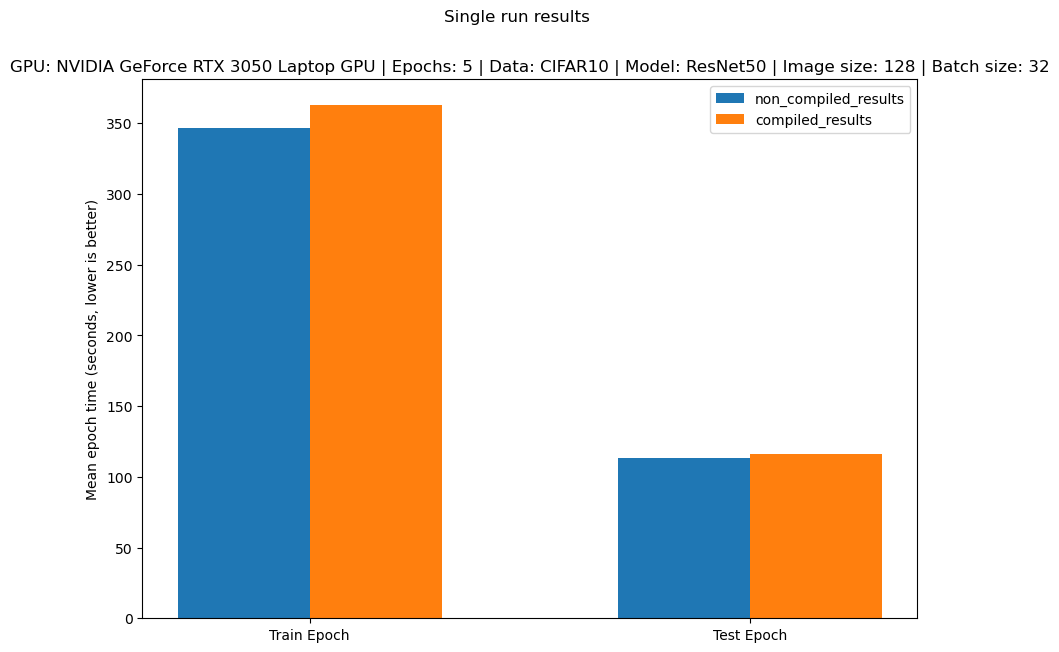

In [79]:
dir_to_save_figures_in = "pytorch_2_results/figures/"
os.makedirs(dir_to_save_figures_in, exist_ok=True)

# Create a save path for the single run results
save_path_single_run = f"{dir_to_save_figures_in}single_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"
print(f"[INFO] Save path for single run results: {save_path_single_run}")

#plot the results and save the figure(s)
plot_mean_epoch_times(non_compiled_results=single_run_no_compile_results_df,
                      compiled_results=single_run_compile_results_df,
                      multi_runs=False,
                      save_path=save_path_single_run)

###3.4 Save single run results to file with GPU details

In [78]:
# Make a directory for single_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_single_run_results_dir = f"{pytorch_2_results_dir}/single_run_results"
os.makedirs(pytorch_2_single_run_results_dir, exist_ok=True)

# Create filenames for each of the dataframes
save_name_for_non_compiled_results = f"single_run_non_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_compiled_results = f"single_run_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

# Create filepaths to save the results to
single_run_no_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_non_compiled_results}"
single_run_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving non-compiled experiment 1 results to: {single_run_no_compile_save_path}")
print(f"[INFO] Saving compiled experiment 2 results to: {single_run_compile_save_path}")

# Save the results
single_run_no_compile_results_df.to_csv(single_run_no_compile_save_path)
single_run_compile_results_df.to_csv(single_run_compile_save_path)

[INFO] Saving non-compiled experiment 1 results to: pytorch_2_results/single_run_results/single_run_non_compiled_results_CIFAR10_ResNet50_NVIDIA_GeForce_RTX_3050_Laptop_GPU.csv
[INFO] Saving compiled experiment 2 results to: pytorch_2_results/single_run_results/single_run_compiled_results_CIFAR10_ResNet50_NVIDIA_GeForce_RTX_3050_Laptop_GPU.csv


##4. Time models across multiple runs
Time for multi-run experiments!

  * Experiment 3 - 3x5 epochs without torch.compile()
  * Experiment 4 - 3x5 epochs with torch.compile()
Before running experiment 3 and 4, let's create 3 functions:

  1. Experiment 3: create_and_train_non_compiled_model() - creates and trains a model for a single run (can put this function in a loop for mulitple runs).
  2. Experiment 4: create_compiled_model() - creates and compiles a model, returns the compiled model.
  3. Experiment 4: train_compiled_model() - trains a compiled model for a single run (can put this in a loop to train for multiple runs).

In [81]:
def create_and_train_non_compiled_model(epochs=NUM_EPOCHS,
                                        learning_rate=LEARNING_RATE,
                                        disable_progress_bar=False): 

    """
    Create and train a non-compiled PyTorch model.
    """
    model, _ = create_model()
    model.to(device)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)
    
    results = train(model=model,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    epochs=epochs,
                    device=device,
                    disable_progress_bar=disable_progress_bar)
    
    return results

def create_compiled_model():
  """
  Create a compiled PyTorch model and return it.
  """ 
  model, _ = create_model()
  model.to(device)

  compile_start_time = time.time()

  ### New in PyTorch 2.0!!! ###
  compiled_model = torch.compile(model)

  compile_end_time = time.time()

  compile_time = compile_end_time - compile_start_time

  print(f"[INFO] Model compile time: {compile_time}")

  return compiled_model

def train_compiled_model(model=compiled_model,
                         epochs=NUM_EPOCHS,
                         learning_rate=LEARNING_RATE,
                         disable_progress_bar=False):
  """
  Train a compiled model and return the results.
  """ 
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(compiled_model.parameters(),
                               lr=learning_rate)
  
  compile_results = train(model=model,
                          train_dataloader=train_dataloader,
                          test_dataloader=test_dataloader,
                          loss_fn=loss_fn,
                          optimizer=optimizer,
                          epochs=epochs,
                          device=device,
                          disable_progress_bar=disable_progress_bar)

  return compile_results

In [82]:
# Run non-compiled model for multiple runs
NUM_RUNS = 3
NUM_EPOCHS = 5

# Create an empty list to store multiple run results
non_compile_results_multiple_runs = []

# Run non-compiled model for multiple runs
for i in tqdm(range(NUM_RUNS)):
    print(f"[INFO] Run {i+1} of {NUM_RUNS} for non-compiled model")
    results = create_and_train_non_compiled_model(epochs=NUM_EPOCHS, disable_progress_bar=True)
    non_compile_results_multiple_runs.append(results)

  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Run 1 of 3 for non-compiled model
Epoch: 1 | train_loss: 1.0893 | train_acc: 0.6116 | test_loss: 0.8261 | test_acc: 0.7150 | train_epoch_time: 299.5057 | test_epoch_time: 98.1829
Epoch: 2 | train_loss: 0.6599 | train_acc: 0.7720 | test_loss: 0.6722 | test_acc: 0.7727 | train_epoch_time: 311.3335 | test_epoch_time: 105.3801
Epoch: 3 | train_loss: 0.5069 | train_acc: 0.8254 | test_loss: 0.5555 | test_acc: 0.8098 | train_epoch_time: 452.6944 | test_epoch_time: 102.8243
Epoch: 4 | train_loss: 0.4027 | train_acc: 0.8615 | test_loss: 0.5306 | test_acc: 0.8212 | train_epoch_time: 445.9756 | test_epoch_time: 102.8739


 33%|███▎      | 1/3 [41:07<1:22:14, 2467.44s/it]

Epoch: 5 | train_loss: 0.3181 | train_acc: 0.8891 | test_loss: 0.4777 | test_acc: 0.8452 | train_epoch_time: 444.7607 | test_epoch_time: 103.2369
[INFO] Run 2 of 3 for non-compiled model
Epoch: 1 | train_loss: 1.2272 | train_acc: 0.5633 | test_loss: 0.9373 | test_acc: 0.6733 | train_epoch_time: 446.3747 | test_epoch_time: 99.9983
Epoch: 2 | train_loss: 0.7552 | train_acc: 0.7391 | test_loss: 0.7637 | test_acc: 0.7491 | train_epoch_time: 445.4625 | test_epoch_time: 99.8072
Epoch: 3 | train_loss: 0.5685 | train_acc: 0.8046 | test_loss: 0.5640 | test_acc: 0.8023 | train_epoch_time: 435.2033 | test_epoch_time: 100.2739
Epoch: 4 | train_loss: 0.4445 | train_acc: 0.8467 | test_loss: 0.5499 | test_acc: 0.8153 | train_epoch_time: 437.3259 | test_epoch_time: 99.4646


 67%|██████▋   | 2/3 [1:26:11<43:26, 2606.90s/it]

Epoch: 5 | train_loss: 0.3584 | train_acc: 0.8755 | test_loss: 0.5025 | test_acc: 0.8312 | train_epoch_time: 439.7248 | test_epoch_time: 100.3063
[INFO] Run 3 of 3 for non-compiled model
Epoch: 1 | train_loss: 1.1367 | train_acc: 0.5946 | test_loss: 0.8132 | test_acc: 0.7227 | train_epoch_time: 440.4763 | test_epoch_time: 100.2339
Epoch: 2 | train_loss: 0.6845 | train_acc: 0.7622 | test_loss: 0.6452 | test_acc: 0.7801 | train_epoch_time: 439.2468 | test_epoch_time: 99.5823
Epoch: 3 | train_loss: 0.5253 | train_acc: 0.8168 | test_loss: 0.5617 | test_acc: 0.8017 | train_epoch_time: 440.6409 | test_epoch_time: 100.3712
Epoch: 4 | train_loss: 0.4117 | train_acc: 0.8586 | test_loss: 0.5089 | test_acc: 0.8308 | train_epoch_time: 439.4755 | test_epoch_time: 100.5382


100%|██████████| 3/3 [2:11:13<00:00, 2624.53s/it]

Epoch: 5 | train_loss: 0.3225 | train_acc: 0.8889 | test_loss: 0.5052 | test_acc: 0.8330 | train_epoch_time: 440.6519 | test_epoch_time: 99.9321


In [84]:
# Go through non_compile_results_multiple_runs and create a dataframe for each run then concatenate them together
non_compile_results_dfs = []
for result in non_compile_results_multiple_runs:
    result_df = pd.DataFrame(result)
    non_compile_results_dfs.append(result_df)
non_compile_results_multiple_runs_df = pd.concat(non_compile_results_dfs)

# Get the averages across the multiple runs
non_compile_results_multiple_runs_df = non_compile_results_multiple_runs_df.groupby(non_compile_results_multiple_runs_df.index).mean()
non_compile_results_multiple_runs_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.151057,0.589851,0.858888,0.703674,395.452212,99.471706
1,0.699830,0.757764,0.693654,0.767272,398.680918,101.589837
2,0.533572,0.815606,0.560394,0.804613,442.846216,101.156436
3,0.419616,0.855626,0.529803,0.822417,440.925649,100.958890
4,0.333009,0.884497,0.495133,0.836462,441.712479,101.158446


In [83]:
# Create compiled model
compiled_model = create_compiled_model()

# Create an empty list to store compiled model results
compiled_results_multiple_runs = []

# Run compiled model for multiple runs
for i in tqdm(range(NUM_RUNS)):
    print(f"[INFO] Run {i+1} of {NUM_RUNS} for compiled model")
    # Train the compiled model (note: the model will only be compiled once and then re-used for subsequent runs)
    results = train_compiled_model(model=compiled_model, epochs=NUM_EPOCHS, disable_progress_bar=True)
    compiled_results_multiple_runs.append(results)

[INFO] Model compile time: 0.011484146118164062


  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Run 1 of 3 for compiled model
Epoch: 1 | train_loss: 1.1399 | train_acc: 0.5934 | test_loss: 0.8302 | test_acc: 0.7143 | train_epoch_time: 440.9326 | test_epoch_time: 100.4997
Epoch: 2 | train_loss: 0.7070 | train_acc: 0.7569 | test_loss: 0.6555 | test_acc: 0.7710 | train_epoch_time: 441.3448 | test_epoch_time: 100.6253
Epoch: 3 | train_loss: 0.5456 | train_acc: 0.8123 | test_loss: 0.5524 | test_acc: 0.8084 | train_epoch_time: 440.4625 | test_epoch_time: 100.5860
Epoch: 4 | train_loss: 0.4253 | train_acc: 0.8528 | test_loss: 0.5451 | test_acc: 0.8205 | train_epoch_time: 441.4580 | test_epoch_time: 100.0408


 33%|███▎      | 1/3 [45:11<1:30:23, 2711.92s/it]

Epoch: 5 | train_loss: 0.3359 | train_acc: 0.8838 | test_loss: 0.5239 | test_acc: 0.8329 | train_epoch_time: 445.6766 | test_epoch_time: 100.2872
[INFO] Run 2 of 3 for compiled model
Epoch: 1 | train_loss: 0.2890 | train_acc: 0.8990 | test_loss: 0.5041 | test_acc: 0.8349 | train_epoch_time: 445.4627 | test_epoch_time: 100.2164
Epoch: 2 | train_loss: 0.2058 | train_acc: 0.9280 | test_loss: 0.5185 | test_acc: 0.8444 | train_epoch_time: 449.9926 | test_epoch_time: 101.3357
Epoch: 3 | train_loss: 0.1523 | train_acc: 0.9467 | test_loss: 0.5084 | test_acc: 0.8539 | train_epoch_time: 353.0010 | test_epoch_time: 108.3729
Epoch: 4 | train_loss: 0.1233 | train_acc: 0.9567 | test_loss: 0.5691 | test_acc: 0.8475 | train_epoch_time: 311.0024 | test_epoch_time: 111.4663


 67%|██████▋   | 2/3 [1:25:18<42:12, 2532.53s/it]

Epoch: 5 | train_loss: 0.0966 | train_acc: 0.9657 | test_loss: 0.5619 | test_acc: 0.8548 | train_epoch_time: 317.6446 | test_epoch_time: 108.4541
[INFO] Run 3 of 3 for compiled model
Epoch: 1 | train_loss: 0.0968 | train_acc: 0.9670 | test_loss: 0.6013 | test_acc: 0.8522 | train_epoch_time: 314.5010 | test_epoch_time: 104.9355
Epoch: 2 | train_loss: 0.0788 | train_acc: 0.9722 | test_loss: 0.5789 | test_acc: 0.8547 | train_epoch_time: 315.7265 | test_epoch_time: 105.2174
Epoch: 3 | train_loss: 0.0687 | train_acc: 0.9763 | test_loss: 0.6220 | test_acc: 0.8525 | train_epoch_time: 313.7326 | test_epoch_time: 105.7897
Epoch: 4 | train_loss: 0.0695 | train_acc: 0.9759 | test_loss: 0.6124 | test_acc: 0.8597 | train_epoch_time: 313.4985 | test_epoch_time: 108.9034


100%|██████████| 3/3 [2:00:27<00:00, 2409.24s/it]

Epoch: 5 | train_loss: 0.0598 | train_acc: 0.9792 | test_loss: 0.6061 | test_acc: 0.8623 | train_epoch_time: 319.2489 | test_epoch_time: 107.3056


In [85]:
# Go through compile_results_multiple_runs and create a dataframe for each run then concatenate them together
compile_results_dfs = []
for result in compiled_results_multiple_runs:
    result_df = pd.DataFrame(result)
    compile_results_dfs.append(result_df)
compile_results_multiple_runs_df = pd.concat(compile_results_dfs)

# Get the averages across the multiple runs
compile_results_multiple_runs_df = compile_results_multiple_runs_df.groupby(compile_results_multiple_runs_df.index).mean() # .index = groupby the epoch number
compile_results_multiple_runs_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,0.508540,0.819764,0.645157,0.800453,400.298736,101.883877
1,0.330550,0.885723,0.584300,0.823383,402.354628,102.392826
2,0.255531,0.911782,0.560945,0.838292,369.065357,104.916177
3,0.206041,0.928470,0.575504,0.842585,355.319653,106.803499
4,0.164079,0.942898,0.563964,0.850007,360.856686,105.348978


###4.3 Compare results of experiment 3 and 4

Mean train epoch time difference: -10.932% (negative means faster)
Mean test epoch time difference: 3.373% (negative means faster)
[INFO] Plot saved to pytorch_2_results/figures/multi_run_NVIDIA_GeForce_RTX_3050_Laptop_GPU_ResNet50_CIFAR10_128_train_epoch_time.png


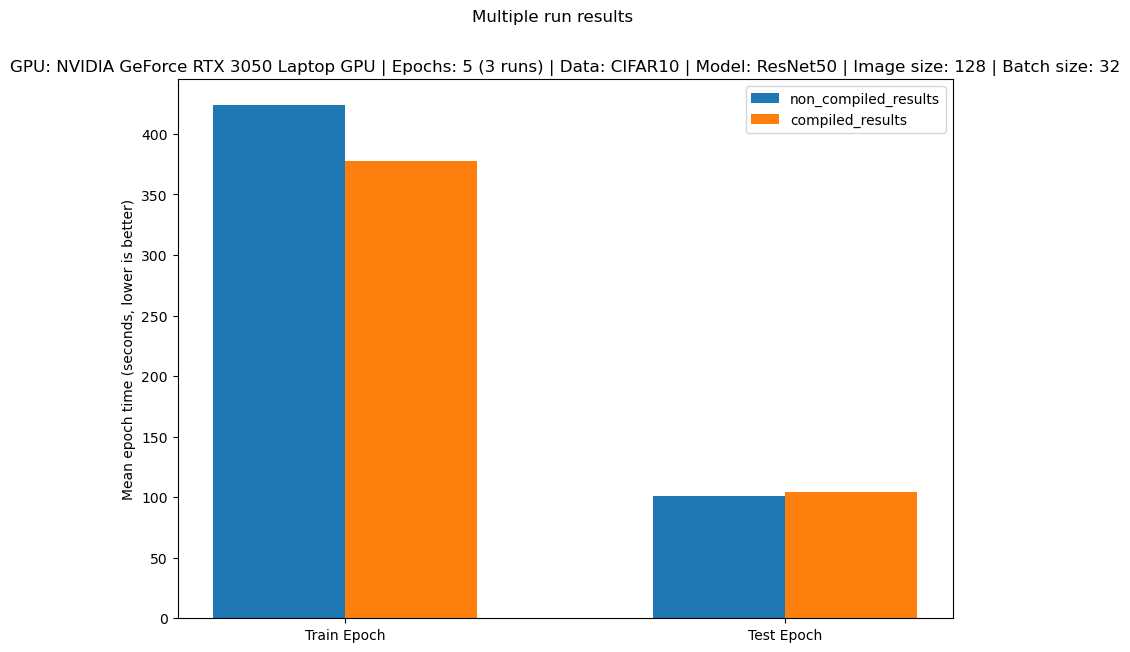

In [86]:
# Create a directory to save the multi-run figure to 
os.makedirs("pytorch_2_results/figures", exist_ok=True)

# Create a path to save the figure for multiple runs
save_path_multi_run = f"pytorch_2_results/figures/multi_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"

# Plot the mean epoch times for experiment 3 and 4
plot_mean_epoch_times(non_compiled_results=non_compile_results_multiple_runs_df, 
                      compiled_results=compile_results_multiple_runs_df, 
                      multi_runs=True, 
                      num_runs=NUM_RUNS, 
                      save_path=save_path_multi_run, 
                      save=True)
     

**ความหมายของผลลัพธ์:**  

1. **Mean train epoch time difference: -10.932%**  
   - เวลาเฉลี่ยในการฝึก (train) ของแต่ละ epoch ลดลง **10.932%** เมื่อเปรียบเทียบระหว่างโมเดลที่ใช้ **PyTorch 2.0 (compiled)** กับโมเดลแบบธรรมดา (non-compiled)  
   - **ค่าลบ (negative)** หมายถึงโมเดลที่ถูก compile เร็วกว่า  

2. **Mean test epoch time difference: 3.373%**  
   - เวลาเฉลี่ยในการทดสอบ (test) ของแต่ละ epoch เพิ่มขึ้น **3.373%** เมื่อใช้โมเดลที่ compile  
   - **ค่าบวก (positive)** หมายถึงการทดสอบ (test) ของโมเดลแบบ compile ใช้เวลานานกว่าเล็กน้อย  

---

### **สรุปผลโดยรวม:**  
- **การฝึก (train)**: PyTorch 2.0 (compiled) ช่วยให้กระบวนการฝึกเร็วขึ้นประมาณ 10.932%  
- **การทดสอบ (test)**: PyTorch 2.0 (compiled) อาจมี overhead เพิ่มขึ้นเล็กน้อยในขั้นตอนการทดสอบ  

---

### **สาเหตุที่การทดสอบช้าลง:**  
1. **Overhead จากการ Optimize Model:**  
   การ compile โมเดลอาจเพิ่มขั้นตอนในระหว่างการรัน (เช่น การ optimize graph)  
2. **ขนาดข้อมูลใน Test:**  
   หากข้อมูลในขั้นตอนการทดสอบมีขนาดเล็ก อาจไม่ได้ใช้ประสิทธิภาพของการ compile เต็มที่  

---



###4.4 Save multi runs results to file with GPU details

In [87]:
# Make a directory for multi_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_multi_run_results_dir = f"{pytorch_2_results_dir}/multi_run_results"
os.makedirs(pytorch_2_multi_run_results_dir, exist_ok=True)

# Create filenames for each of the dataframes
save_name_for_multi_run_non_compiled_results = f"multi_run_non_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_multi_run_compiled_results = f"multi_run_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

# Create filepaths to save the results to
multi_run_no_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_non_compiled_results}"
multi_run_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving experiment 3 non-compiled results to: {multi_run_no_compile_save_path}")
print(f"[INFO] Saving experiment 4 compiled results to: {multi_run_compile_save_path}")

# Save the results
non_compile_results_multiple_runs_df.to_csv(multi_run_no_compile_save_path)
compile_results_multiple_runs_df.to_csv(multi_run_compile_save_path)

[INFO] Saving experiment 3 non-compiled results to: pytorch_2_results/multi_run_results/single_run_non_compiled_results_CIFAR10_ResNet50_NVIDIA_GeForce_RTX_3050_Laptop_GPU.csv
[INFO] Saving experiment 4 compiled results to: pytorch_2_results/multi_run_results/single_run_compiled_results_CIFAR10_ResNet50_NVIDIA_GeForce_RTX_3050_Laptop_GPU.csv


### 5. การปรับปรุงและการขยายที่เป็นไปได้  

1. **ใช้ CPU ที่ทรงพลังขึ้น**  
   - ช่วยโหลดข้อมูลไปยัง GPU ได้เร็วขึ้น  
   - ความเร็วสัมพัทธ์ (relative speedups) จะดีขึ้นเมื่อ GPU ถูกใช้งานเต็มประสิทธิภาพ  

2. **ใช้การฝึกแบบ Mixed Precision**  
   - ผสมระหว่าง float32 และ float16  
   - ช่วยลดเวลาในการฝึกโมเดล  

3. **ใช้โมเดลแบบ Transformer แทน Convolutional**  
   - โมเดลแบบ Transformer อาจได้รับความเร็วสัมพัทธ์มากกว่าจากการ optimize  

4. **ฝึกโมเดลนานขึ้น**  
   - ยิ่งฝึกโมเดลนานขึ้น จะยิ่งได้รับประโยชน์จากการ optimize ของ `torch.compile()`  

ดูเพิ่มเติมได้ที่: [Learn PyTorch](https://www.learnpytorch.io/pytorch_2_intro/#5-possible-improvements-and-extensions)  

##6. Resources to learn more

See here: https://www.learnpytorch.io/pytorch_2_intro/#6-resources-to-learn-more